In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import rotate
from skimage.color import rgb2gray
from deskew import determine_skew

import pytesseract
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import RANSACRegressor
import seaborn as sns

from os import listdir
from os.path import isfile, join
import imutils
import warnings 
warnings.filterwarnings("ignore")

from utils import Preprocess, Blind_image_adjustment
%load_ext autoreload
%autoreload 2


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### This notebook is for the blind re-ajustment without using the original image

## Load Data

In [414]:
mypath = '../data/imagesprojets5/photo/'
# mypath = '../data/screens_phone/'

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
image = 9

img_file = onlyfiles[image]

img = cv2.imread(mypath + img_file) #reading the image
# img = cv2.imread('../data/test_3.png') #reading the image



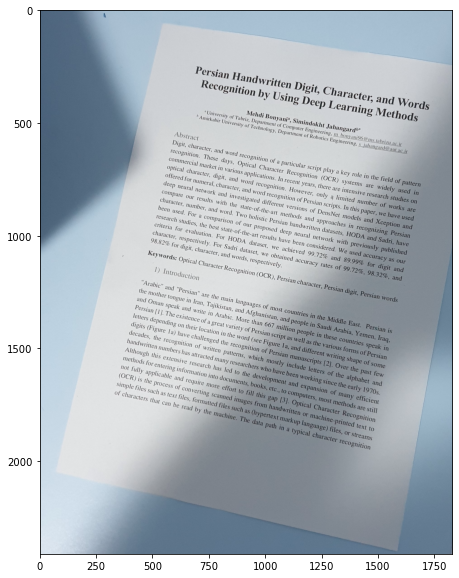

In [416]:
plt.figure(figsize=(10,10))
plt.imshow(img)

## Pre-process images

In [417]:
%%time
##### Preprocessing
preprocessor = Preprocess()
img =  preprocessor.remove_shadows(img.copy())
angle_desk,img  = preprocessor.deskew(img.copy())
edges = preprocessor.edge_detection(img.copy())
lines = preprocessor.line_detection(edges)
lines = preprocessor.filter_hough_lines(lines,edges)
##### Computing lines and angles
angles_deg = preprocessor.compute_angles(lines)
rot_angles = preprocessor.adjust_angles(angles_deg)
lines_candidates = preprocessor.filter_lines_direction(lines,rot_angles,angle_desk)
# lines_candidates = preprocessor.remove_outliers(lines_candidates)
# longest_lines = preprocessor.get_longest_lines(lines_candidates, percentile_thresh=75)


-23.317039106145245
Wall time: 3.76 s


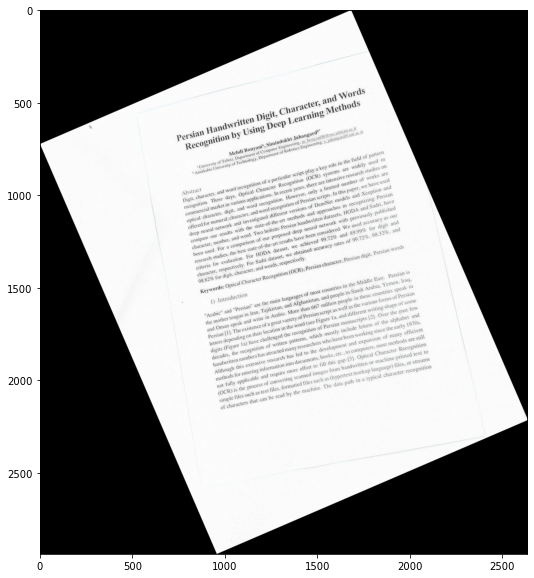

In [418]:
plt.figure(figsize=(10,10))
plt.imshow(img)

# Adjust Images

In [419]:
##### adjusting blind image
blind_image_adjustor = Blind_image_adjustment(img,lines_candidates,img.shape[0])
_ = blind_image_adjustor.find_perfect_rectangle()
edge_lines = blind_image_adjustor.compute_edge_lines()
_= blind_image_adjustor.find_corners(edge_lines, do_assert=Trye) # Make do_assert=False for debugging 
im_out = blind_image_adjustor.adjust_image(margin=100)

##### The following part is only for debuging and intermediate visualization and can be dropped

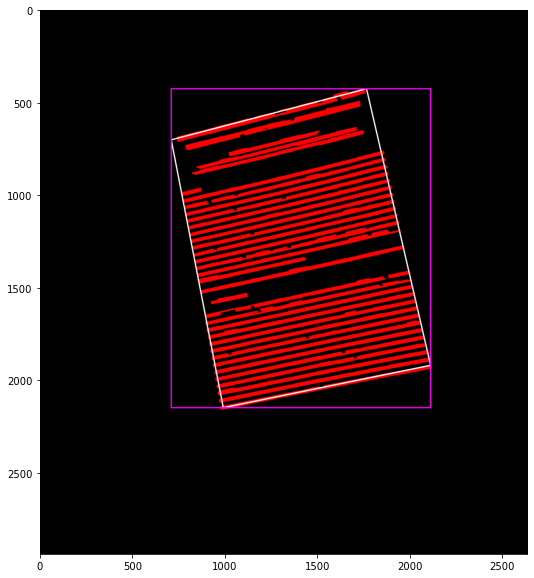

In [420]:
x_top_left, y_top_left, x_low_left, y_low_left, x_top_right, y_top_right, x_low_right,y_low_right = blind_image_adjustor.corners
x_max,x_min,y_max,y_min = blind_image_adjustor.x_max,blind_image_adjustor.x_min,blind_image_adjustor.y_max,blind_image_adjustor.y_min

line_image_candidates = np.copy(img)*0   # creating a blank to draw lines on
for line in lines_candidates[:]:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image_candidates,(x1,y1),(x2,y2),(255,0,0),5)

x_top_left,y_top_left,x_low_left,y_low_left,x_top_right,y_top_right,x_low_right,y_low_right = blind_image_adjustor.corners  

cv2.line(line_image_candidates,(x_low_right,y_low_right),(x_low_left,y_low_left),(255,255,255),5)
cv2.line(line_image_candidates,(x_top_right,y_top_right),(x_top_left,y_top_left),(255,255,255),5)
cv2.line(line_image_candidates,(x_low_right,y_low_right),(x_top_right,y_top_right),(255,255,255),5)
cv2.line(line_image_candidates,(x_low_left,y_low_left),(x_top_left,y_top_left),(255,255,255),5)

cv2.line(line_image_candidates,(x_min,y_min),(x_min,y_max),(255,0,255),5)
cv2.line(line_image_candidates,(x_min,y_min),(x_max,y_min),(255,0,255),5)
cv2.line(line_image_candidates,(x_min,y_max),(x_max,y_max),(255,0,255),5)
cv2.line(line_image_candidates,(x_max,y_max),(x_max,y_min),(255,0,255),5)


plt.figure(figsize=(15,10))
plt.imshow(line_image_candidates)       

## Visualize Results (redressed Image)

Text(0.5, 1.0, 'Text area adjusted using the 4 corners + a buffer of 100 px')

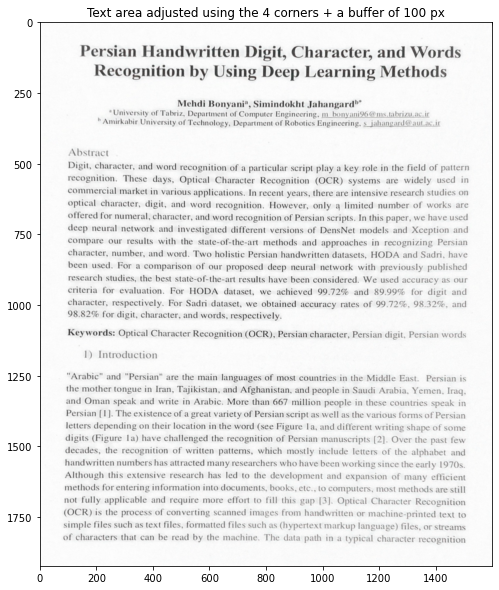

In [421]:
plt.figure(figsize=(15,10))
plt.imshow(im_out)
plt.title('Text area adjusted using the 4 corners + a buffer of 100 px')

# Run pytesseract

In [422]:
im_tesseract = im_out.copy()

In [423]:
%%time 
d = pytesseract.image_to_data(im_tesseract, output_type=pytesseract.Output.DICT)

Wall time: 3.82 s


Text(0.5, 1.0, 'Text and distances extracted using pytesseract')

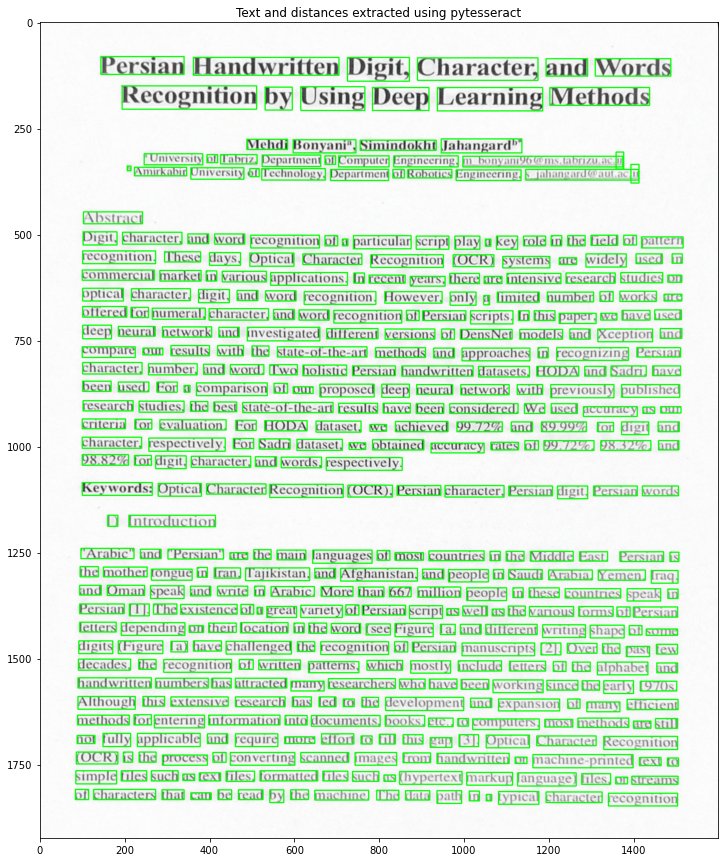

In [424]:
plt.rcParams["figure.figsize"] = [20,15]
n_boxes = len(d['level'])
level = 5
words_coords = []
for i in range(n_boxes):
    if d['level'][i] == level:
        word = {}
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        word['x'] = x
        word['y'] = y
        word['w'] = w
        word['h'] = h
        word['text'] = d['text'][i]
        words_coords.append(word)
        cv2.rectangle(im_tesseract, (x, y), (x + w, y + h), (0, 255, 0), 2)
plt.imshow(im_tesseract)
plt.title('Text and distances extracted using pytesseract')

# Finally we get a dictionnary of word distances

In [425]:
words_coords

[{'x': 143, 'y': 81, 'w': 196, 'h': 42, 'text': 'Persian'},
 {'x': 361, 'y': 83, 'w': 343, 'h': 42, 'text': 'Handwritten'},
 {'x': 724, 'y': 83, 'w': 146, 'h': 56, 'text': 'Digit,'},
 {'x': 889, 'y': 84, 'w': 284, 'h': 53, 'text': 'Character,'},
 {'x': 1192, 'y': 86, 'w': 98, 'h': 41, 'text': 'and'},
 {'x': 1308, 'y': 86, 'w': 178, 'h': 41, 'text': 'Words'},
 {'x': 193, 'y': 150, 'w': 317, 'h': 55, 'text': 'Recognition'},
 {'x': 530, 'y': 153, 'w': 64, 'h': 54, 'text': 'by'},
 {'x': 614, 'y': 152, 'w': 151, 'h': 56, 'text': 'Using'},
 {'x': 783, 'y': 154, 'w': 133, 'h': 54, 'text': 'Deep'},
 {'x': 936, 'y': 154, 'w': 248, 'h': 55, 'text': 'Learning'},
 {'x': 1201, 'y': 154, 'w': 235, 'h': 42, 'text': 'Methods'},
 {'x': 487, 'y': 276, 'w': 96, 'h': 24, 'text': 'Mehdi'},
 {'x': 596, 'y': 277, 'w': 148, 'h': 31, 'text': 'Bonyani",'},
 {'x': 754, 'y': 278, 'w': 179, 'h': 24, 'text': 'Simindokht'},
 {'x': 945, 'y': 275, 'w': 190, 'h': 33, 'text': 'Jahangard””'},
 {'x': 245, 'y': 310, 'w': 1